## Limited ML Testing

- Using smaller yelp dataset of just category counts without restaurant breakdowns
- Use cleanded zillow set as is

In [1]:
# Dependencies - General
import os
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from functools import reduce
from collections import Counter

In [37]:
# Import ML libraries and tools
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import EasyEnsembleClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

### Load Data

In [3]:
# Yelp restaurant data without breakdown of all category types
path1 = os.path.join("..", "Processed_Data", "yelp_summary_by_zip.csv")
yelp_df = pd.read_csv(path1)

In [4]:
yelp_df

,postal_code,total_restaurants,avg_stars,total_reviews,num_rest_categories
0,8001,2,3.750000,18.0,6
1,8002,96,3.276042,9827.0,61
2,8003,43,3.651163,3314.0,51
3,8004,8,3.125000,160.0,11
4,8005,1,3.500000,7.0,2
...,...,...,...,...,...
840,93118,2,3.500000,21.0,8
841,93190,3,3.500000,758.0,8
842,93642,1,3.500000,45.0,6
843,95661,1,2.500000,11.0,3


In [5]:
# Zillow dataset from repository
path2 = os.path.join("..", "Restaurants_and_House_Prices", "Resources", "zillow_housing_final_cleaned.csv")
zillow_df = pd.read_csv(path2)

In [6]:
zillow_df

,Unnamed: 0,postal_code,State,City,CountyName,2021
0,0,10025,NY,New York,New York County,1114145
1,1,60657,IL,Chicago,Cook County,508407
2,2,10023,NY,New York,New York County,1450186
3,3,77494,TX,Katy,Harris County,404243
4,4,60614,IL,Chicago,Cook County,648360
...,...,...,...,...,...,...
27691,30461,27708,NC,Durham,Durham County,322788
27692,30462,47865,IN,Carlisle,Sullivan County,59546
27693,30463,20052,DC,Washington,District of Columbia,1437647
27694,30465,12345,OR,Central Point,Jackson County,179003


In [7]:
# Neighborhood Tiers from repository
path3 = os.path.join("..", "Restaurants_and_House_Prices", "Resources", "neighborhood_tier_final.csv")
neighborhoods_df = pd.read_csv(path3)
# This contains joined and further processed table for ML modeling

In [8]:
neighborhoods_df

,postal_code,State,City,CountyName,2021,total_restaurants,avg_stars,total_reviews,BubbleTea,Coffee&Tea,...,EasternEuropean_stars,Cucinacampana_stars,ConveyorBeltSushi_stars,Poutineries_stars,Coffeeshops_stars,SerboCroatian_stars,num_rest_categories,Average County House Price,Neighborhood Indicator,Neighborhood Tiers
0,37013,TN,Nashville,Davidson County,295552,83,3.096386,4257.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,60,439999.0,0.671711,3
1,37211,TN,Nashville,Davidson County,340382,182,3.491758,12761.0,2.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,92,439999.0,0.773597,2
2,37221,TN,Nashville,Davidson County,401000,69,3.217391,6690.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,57,439999.0,0.911366,2
3,37209,TN,Nashville,Davidson County,445902,147,3.772109,16663.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93,439999.0,1.013416,2
4,37076,TN,Nashville,Davidson County,328591,81,3.228395,4994.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53,439999.0,0.746799,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,62558,IL,Pawnee,Sangamon County,141417,1,2.500000,16.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,141417.0,1.000000,2
746,38066,TN,Rossville,Fayette County,371584,1,3.500000,32.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,371584.0,1.000000,2
747,37012,TN,Alexandria,Dekalb County,167883,1,4.000000,192.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,167883.0,1.000000,2
748,37026,TN,Bradyville,Cannon County,189305,1,4.500000,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,189305.0,1.000000,2


In [9]:
neighborhoods_df.columns

Index(['postal_code', 'State', 'City', 'CountyName', '2021',
       'total_restaurants', 'avg_stars', 'total_reviews', 'BubbleTea',
       'Coffee&Tea',
       ...
       'EasternEuropean_stars', 'Cucinacampana_stars',
       'ConveyorBeltSushi_stars', 'Poutineries_stars', 'Coffeeshops_stars',
       'SerboCroatian_stars', 'num_rest_categories',
       'Average County House Price', 'Neighborhood Indicator',
       'Neighborhood Tiers'],
      dtype='object', length=428)

In [10]:
# make a new limited data set df
limited_df = neighborhoods_df[['postal_code','2021','total_restaurants', 'avg_stars', 'total_reviews','num_rest_categories', 'Neighborhood Tiers']]

In [11]:
limited_df.set_index(['postal_code'], inplace=True)

In [12]:
limited_df.rename(columns={"Neighborhood Tiers":"tiers"}, inplace=True)

/var/folders/mf/k1c72g5j2zx32w4qpq9tbwpw0000gn/T/ipykernel_82571/1029653185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_df.rename(columns={"Neighborhood Tiers":"tiers"}, inplace=True)


In [13]:
limited_df

,2021,total_restaurants,avg_stars,total_reviews,num_rest_categories,tiers
postal_code,,,,,,
37013,295552,83,3.096386,4257.0,60,3
37211,340382,182,3.491758,12761.0,92,2
37221,401000,69,3.217391,6690.0,57,2
37209,445902,147,3.772109,16663.0,93,2
37076,328591,81,3.228395,4994.0,53,3
...,...,...,...,...,...,...
62558,141417,1,2.500000,16.0,4,2
38066,371584,1,3.500000,32.0,3,2
37012,167883,1,4.000000,192.0,2,2


In [14]:
limited_df.columns

Index(['2021', 'total_restaurants', 'avg_stars', 'total_reviews',
       'num_rest_categories', 'tiers'],
      dtype='object')

## Set up data for models

In [15]:
# Targets and Features
X = limited_df.drop(columns="tiers")
y = limited_df["tiers"]

In [16]:
X

,2021,total_restaurants,avg_stars,total_reviews,num_rest_categories
postal_code,,,,,
37013,295552,83,3.096386,4257.0,60
37211,340382,182,3.491758,12761.0,92
37221,401000,69,3.217391,6690.0,57
37209,445902,147,3.772109,16663.0,93
37076,328591,81,3.228395,4994.0,53
...,...,...,...,...,...
62558,141417,1,2.500000,16.0,4
38066,371584,1,3.500000,32.0,3
37012,167883,1,4.000000,192.0,2


In [17]:
y

postal_code
37013    3
37211    2
37221    2
37209    2
37076    3
        ..
62558    2
38066    2
37012    2
37026    2
85619    2
Name: tiers, Length: 750, dtype: int64

In [18]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [19]:
# Scale Data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Try some models

### Random Forest

In [20]:
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

rf_model = rf_model.fit(X_train_scaled, y_train)

In [21]:
# Predict
predictions = rf_model.predict(X_test_scaled)

In [22]:
predictions

array([3, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 3, 1, 1, 2, 2, 2, 2, 2, 1, 3, 1, 3, 2, 2, 3, 1, 1, 3,
       1, 2, 1, 3, 2, 2, 2, 2, 2, 3, 2, 3, 1, 2, 1, 1, 1, 2, 2, 3, 1, 2,
       1, 3, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 3, 2, 3, 1, 1, 3, 2,
       2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 3, 3, 2, 2, 2,
       2, 2, 1, 3, 2, 2, 1, 3, 2, 3, 2, 1, 2, 1, 3, 3, 2, 1, 2, 3, 2, 3,
       2, 2, 2, 2, 1, 3, 2, 1, 2, 3, 2, 3, 3, 2, 2, 1, 3, 2, 1, 3, 1, 2,
       2, 3, 2, 1, 3, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2,
       3, 1, 2, 1, 1, 3, 3, 3, 2, 1, 1, 1])

In [23]:
# Look at importance of model features (which columns contribute more to the prediction):
importances = rf_model.feature_importances_
importances # Returns array with ratio

array([0.40024801, 0.13023953, 0.16870284, 0.16873488, 0.13207474])

In [24]:
# Sort features by importance (See the importance and column)
sorted(zip(rf_model.feature_importances_, X.columns),reverse=True)

[(0.4002480143623607, '2021'),
 (0.1687348836265062, 'total_reviews'),
 (0.16870283786283433, 'avg_stars'),
 (0.13207473516863094, 'num_rest_categories'),
 (0.13023952897966792, 'total_restaurants')]

In [25]:
# Evaluations
report = classification_report(y_test, predictions)
print(report)


              precision    recall  f1-score   support

           1       0.60      0.68      0.64        47
           2       0.61      0.64      0.62        92
           3       0.61      0.47      0.53        49

    accuracy                           0.61       188
   macro avg       0.61      0.60      0.60       188
weighted avg       0.61      0.61      0.60       188



In [26]:
# Cast results into a dataframe
Results_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test})

In [27]:
Results_df

,Prediction,Actual
postal_code,,
46235,3,2
19076,2,3
63303,2,2
18962,2,2
8046,2,3
...,...,...
62298,3,2
85730,2,3
8530,1,2


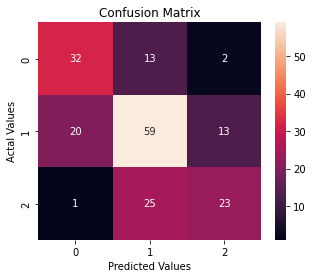

In [29]:
# PLOT!
import seaborn as sns

# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Tier1','Tier2','Tier3'], 
                     columns = ['Tier1','Tier2','Tier3'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()



### Boosted Random Tree Forest

In [32]:
# Play around to select the best learning rate
learning_rates = [0.1, 0.2, 0.25, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.75, 0.8, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)
    # Fit the model
    classifier.fit(X_train_scaled, y_train)
    # Print out scores for each loop (should improve)
    print(f'Learning Rate: {learning_rate}')
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train_scaled,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test_scaled,
            y_test)))
    print()

Learning Rate: 0.1
Accuracy score (training): 0.737
Accuracy score (validation): 0.489

Learning Rate: 0.2
Accuracy score (training): 0.799
Accuracy score (validation): 0.484

Learning Rate: 0.25
Accuracy score (training): 0.829
Accuracy score (validation): 0.569

Learning Rate: 0.3
Accuracy score (training): 0.856
Accuracy score (validation): 0.527

Learning Rate: 0.4
Accuracy score (training): 0.899
Accuracy score (validation): 0.559

Learning Rate: 0.45
Accuracy score (training): 0.916
Accuracy score (validation): 0.527

Learning Rate: 0.5
Accuracy score (training): 0.927
Accuracy score (validation): 0.569

Learning Rate: 0.55
Accuracy score (training): 0.950
Accuracy score (validation): 0.569

Learning Rate: 0.6
Accuracy score (training): 0.938
Accuracy score (validation): 0.511

Learning Rate: 0.65
Accuracy score (training): 0.964
Accuracy score (validation): 0.537

Learning Rate: 0.75
Accuracy score (training): 0.970
Accuracy score (validation): 0.505

Learning Rate: 0.8
Accuracy

In [33]:
# Select learning rate of 0.55
classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.55,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)
# Fit the model
classifier.fit(X_train_scaled, y_train)
# Make Prediction
predictions2 = classifier.predict(X_test_scaled)

In [34]:
# Evaluations
report2 = classification_report(y_test, predictions2)
print(report2)

              precision    recall  f1-score   support

           1       0.53      0.66      0.59        47
           2       0.57      0.64      0.61        92
           3       0.63      0.35      0.45        49

    accuracy                           0.57       188
   macro avg       0.58      0.55      0.55       188
weighted avg       0.58      0.57      0.56       188



In [35]:
# Cast results into a dataframe
Results2_df = pd.DataFrame({"Prediction": predictions2, "Actual": y_test})
Results2_df

,Prediction,Actual
postal_code,,
46235,3,2
19076,2,3
63303,2,2
18962,2,2
8046,2,3
...,...,...
62298,2,2
85730,2,3
8530,1,2


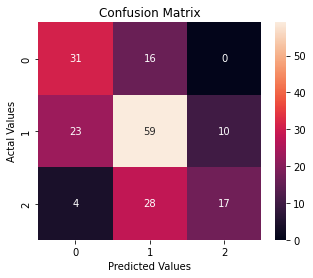

In [36]:
# PLOT!

# Display the confusion matrix
cm2 = confusion_matrix(y_test, predictions2)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm2_df = pd.DataFrame(cm2,
                     index = ['Tier1','Tier2','Tier3'], 
                     columns = ['Tier1','Tier2','Tier3'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


### Easy Ensemble AdaBoost


In [38]:
# Model
model_Ada = EasyEnsembleClassifier(n_estimators=100, random_state=1) 
model_Ada.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [39]:
# Calculated the balanced accuracy score
prediction3 = model_Ada.predict(X_test_scaled)

balanced_accuracy_score(y_test, prediction3)

0.5700614195724544

In [40]:
Results3_df = pd.DataFrame({"Prediction": prediction3, "Actual": y_test})
Results3_df

,Prediction,Actual
postal_code,,
46235,3,2
19076,1,3
63303,2,2
18962,1,2
8046,1,3
...,...,...
62298,1,2
85730,3,3
8530,1,2


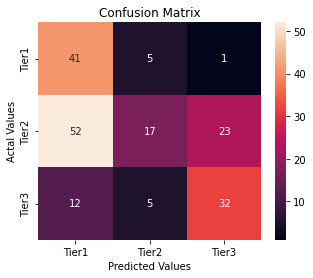

In [41]:
# Display the confusion matrix
cm3 = confusion_matrix(y_test, prediction3)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm3_df = pd.DataFrame(cm3,
                     index = ['Tier1','Tier2','Tier3'], 
                     columns = ['Tier1','Tier2','Tier3'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm3_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()



In [42]:
# Evaluations
report3 = classification_report(y_test, prediction3)
print(report3)

              precision    recall  f1-score   support

           1       0.39      0.87      0.54        47
           2       0.63      0.18      0.29        92
           3       0.57      0.65      0.61        49

    accuracy                           0.48       188
   macro avg       0.53      0.57      0.48       188
weighted avg       0.55      0.48      0.43       188

